In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!kaggle datasets download anggabaguss/botol-mineral
!mkdir dataset

 99% 1.42G/1.43G [00:11<00:00, 144MB/s]
100% 1.43G/1.43G [00:11<00:00, 139MB/s]


In [3]:
!unzip /content/botol-mineral.zip -d /content/dataset

Archive:  /content/botol-mineral.zip
  inflating: /content/dataset/Botol Aqua/IMG_20230507_205031.jpg  
  inflating: /content/dataset/Botol Aqua/IMG_20230507_205034.jpg  
  inflating: /content/dataset/Botol Aqua/IMG_20230507_205036.jpg  
  inflating: /content/dataset/Botol Aqua/IMG_20230507_205038.jpg  
  inflating: /content/dataset/Botol Aqua/IMG_20230507_205040.jpg  
  inflating: /content/dataset/Botol Aqua/IMG_20230507_205043.jpg  
  inflating: /content/dataset/Botol Aqua/IMG_20230507_205045.jpg  
  inflating: /content/dataset/Botol Aqua/IMG_20230507_205047.jpg  
  inflating: /content/dataset/Botol Aqua/IMG_20230507_205049.jpg  
  inflating: /content/dataset/Botol Aqua/IMG_20230507_205050.jpg  
  inflating: /content/dataset/Botol Aqua/IMG_20230507_205052.jpg  
  inflating: /content/dataset/Botol Aqua/IMG_20230507_205054.jpg  
  inflating: /content/dataset/Botol Aqua/IMG_20230507_205055.jpg  
  inflating: /content/dataset/Botol Aqua/IMG_20230507_205105.jpg  
  inflating: /content/dat

In [4]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [5]:
dataset_path = Path(r'/content/dataset')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [6]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/dataset/Botol Aqua/IMG_20230507_21014...,Botol Aqua
1,/content/dataset/Botol Aqua/IMG_20230507_20525...,Botol Aqua
2,/content/dataset/Botol Aqua/IMG_20230507_20560...,Botol Aqua
3,/content/dataset/Botol Aqua/IMG_20230507_20564...,Botol Aqua
4,/content/dataset/Botol Aqua/IMG_20230507_20531...,Botol Aqua


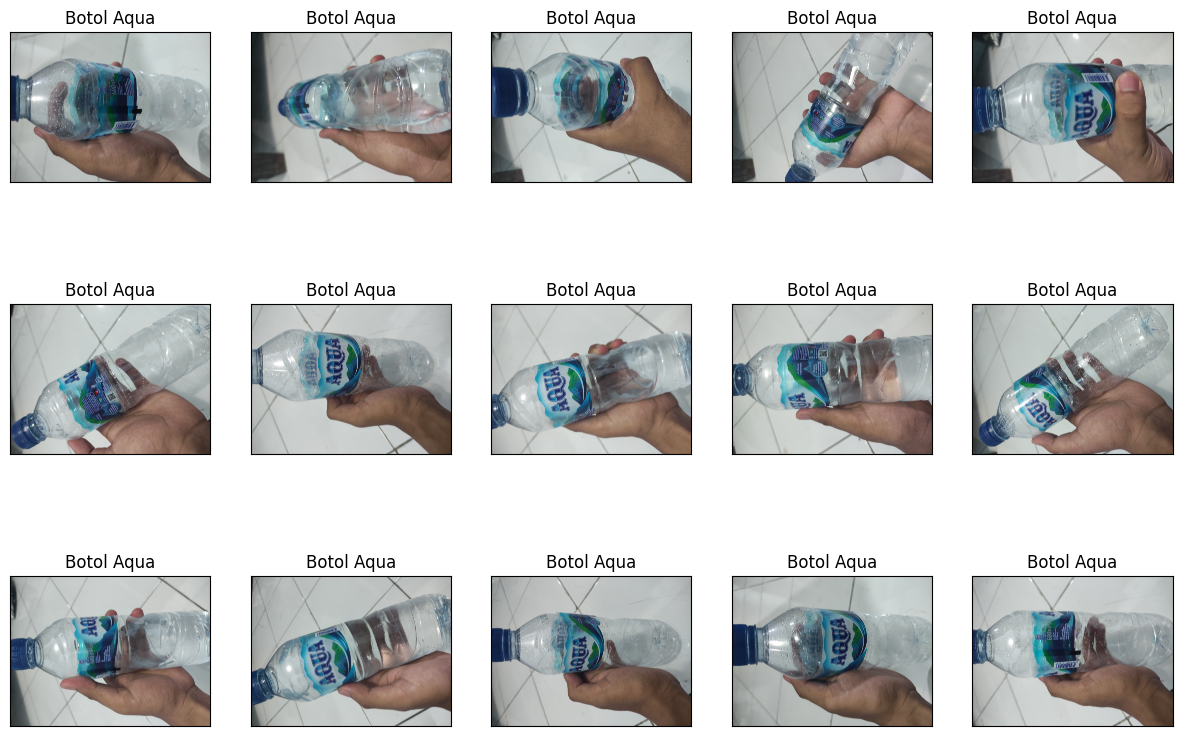

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [8]:
df.label.value_counts()

Botol Nestle Pure Life    121
Botol Le Minerale         117
Botol Aqua                116
Name: label, dtype: int64

In [9]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Botol Nestle Pure Life    121
Botol Le Minerale         117
Botol Aqua                116
Name: label, dtype: int64

In [10]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [11]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (197, 2)
Shape of test data (107, 2)
Shape of validation data (50, 2)


In [12]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 197 validated image filenames belonging to 3 classes.
Found 107 validated image filenames belonging to 3 classes.
Found 50 validated image filenames belonging to 3 classes.


In [13]:
input_shape = (200, 200, 3)

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [16]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 512, validation_data=val, epochs=50, callbacks=callback)

Epoch 1/50
7/7 [==============================] - 84s 12s/step - loss: 1.0897 - accuracy: 0.4467 - val_loss: 1.0727 - val_accuracy: 0.6000
Epoch 2/50
7/7 [==============================] - 72s 10s/step - loss: 1.0294 - accuracy: 0.4569 - val_loss: 0.9130 - val_accuracy: 0.5600
Epoch 3/50
7/7 [==============================] - 72s 10s/step - loss: 0.9416 - accuracy: 0.5787 - val_loss: 0.8161 - val_accuracy: 0.7200
Epoch 4/50
7/7 [==============================] - 72s 10s/step - loss: 0.8297 - accuracy: 0.6701 - val_loss: 0.6709 - val_accuracy: 0.7000
Epoch 5/50
7/7 [==============================] - 72s 10s/step - loss: 0.5702 - accuracy: 0.7259 - val_loss: 0.7179 - val_accuracy: 0.6400
Epoch 6/50
7/7 [==============================] - 71s 10s/step - loss: 0.6581 - accuracy: 0.6904 - val_loss: 0.6101 - val_accuracy: 0.7400
Epoch 7/50
7/7 [==============================] - 73s 11s/step - loss: 0.5525 - accuracy: 0.7259 - val_loss: 0.6175 - val_accuracy: 0.6800
Epoch 8/50
7/7 [===========

In [17]:
model.save('model-1.h5')

In [18]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

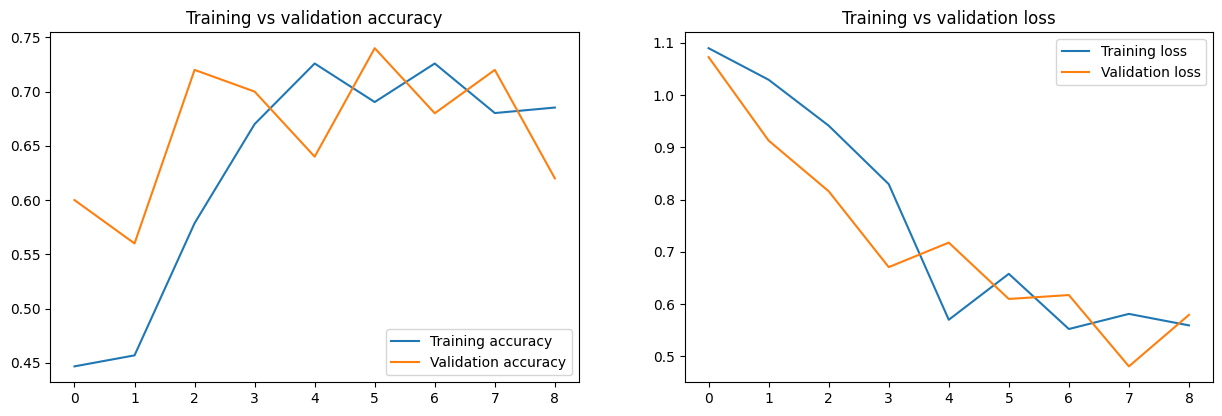

In [19]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [20]:
pred = model.predict(test)

4/4 [==============================] - 31s 7s/step


In [21]:
pred = np.argmax(pred, axis=1)

In [22]:
labels = train.class_indices

In [23]:
labels

{'Botol Aqua': 0, 'Botol Le Minerale': 1, 'Botol Nestle Pure Life': 2}

In [24]:
labels = dict((v,k) for k, v in labels.items())

In [25]:
labels

{0: 'Botol Aqua', 1: 'Botol Le Minerale', 2: 'Botol Nestle Pure Life'}

In [26]:
y_pred = [labels[k] for k in pred]

In [27]:
print(classification_report(x_test.label, y_pred))

                        precision    recall  f1-score   support

            Botol Aqua       0.72      0.33      0.45        40
     Botol Le Minerale       0.91      1.00      0.95        30
Botol Nestle Pure Life       0.54      0.81      0.65        37

              accuracy                           0.68       107
             macro avg       0.72      0.71      0.68       107
          weighted avg       0.71      0.68      0.66       107



In [28]:
print(confusion_matrix(x_test.label, y_pred))

[[13  1 26]
 [ 0 30  0]
 [ 5  2 30]]


In [29]:
test_accuracy = model.evaluate(test)[1]

4/4 [==============================] - 32s 7s/step - loss: 0.6108 - accuracy: 0.6355
